# Groupby 

files needed = ('Most-Recent-Cohorts-Scorecard-Elements.csv')

We often want to know how groups differ. Do workers with econ degrees make more than workers with history degrees? Do men live longer than women? Does it matter how much education you have? 

Pandas provides the `groupby( )` method to ease computing statistics by group ([docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)). This kind of method shows up in many data-oriented computing languages and packages. The idea is summed up as 

> split-apply-combine

Here is the canonical [illustration](https://www.oreilly.com/library/view/learning-pandas/9781783985128/ch09s02.html). The big idea is to 
1. **Split** the data up into groups. The groups are defined by *key* variables.
2. **Apply** some method or function to each group: mean, std, max, etc. This returns a smaller bit of data, often just one number.
3. **Combine** the results of the 'apply' from each group into a new data structure.
  

In [311]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('precision', 3)       # this tells pandas to print out 3 decimal places when we print a DataFrame

## College Scorecard
Let's take this opportunity to learn about a new dataset: [The College Scorecard](https://collegescorecard.ed.gov/data/). The data are compiled by the Dept. of Education to help students evaluate higher education institutions. The data are very well documented and include such juicy variables as: prices, after program debt levels, earnings, completion rates, information about student outcomes by family income and other demographic variables. 

We will be working off of the 'most recent data' file. It is in our shared folder, but you can also get it from [here](https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-Scorecard-Elements.csv).

In [312]:
colscd = pd.read_csv('college_scorecard/Most-Recent-Cohorts-Scorecard-Elements.csv')
colscd.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,INSTURL,NPCURL,HCM2,PREDDEG,...,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GT_25K_P6,GT_28K_P6,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,0,3,...,0.767,0.086,31000,0.453,0.431,32750,348.16551225731,0.2531554273,NaN,0.2913
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,0,3,...,0.518,0.236,41200,0.669,0.631,21833,232.106797835537,0.513963161,NaN,0.5384
2,100690,2503400,25034,Amridge University,Montgomery,AL,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,0,3,...,0.844,0.857,39600,0.658,0.542,22890,243.343773299842,0.2307692308,NaN,PrivacySuppressed
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,www.uah.edu,finaid.uah.edu/,0,3,...,0.431,0.226,46700,0.685,0.649,22647,240.760438353933,0.5485090298,NaN,0.4905
4,100724,100500,1005,Alabama State University,Montgomery,AL,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,0,3,...,0.811,0.097,27700,0.393,0.351,31500,334.876752247489,0.2185867473,NaN,0.2475


This dataset is too big for our needs. Let's rename the variables to something easier to understand and keep just a few variables that look interesting. 

In [313]:
colscd = colscd.rename(columns = {'CONTROL':'ownership', 'INSTNM':'name', 'STABBR':'state', 'PREDDEG':'type', 'SATVRMID':'sat_read_med', 
                      'SATMTMID':'sat_math_med', 'SATWRMID':'sat_write_med', 'PCIP24':'sh_las', 'PCIP51':'sh_bus',
                     'PCIP11':'sh_cs', 'MD_EARN_WNE_P10':'earn_10', 'GRAD_DEBT_MDN_SUPP':'debt_at_grad'})

In [314]:
cols_to_keep = ['name', 'state', 'ownership', 'type','sat_read_med',  'sat_math_med', 'sat_write_med',
                'sh_las', 'sh_bus', 'sh_cs', 'earn_10', 'debt_at_grad']

colscd = colscd[cols_to_keep]

colscd.head()

,name,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_las,sh_bus,sh_cs,earn_10,debt_at_grad
0,Alabama A & M University,AL,1,3,425.0,420.0,414.0,0.066,0.000,0.040,31000,32750
1,University of Alabama at Birmingham,AL,1,3,560.0,575.0,NaN,0.013,0.250,0.013,41200,21833
2,Amridge University,AL,2,3,NaN,NaN,NaN,0.089,0.000,0.000,39600,22890
3,University of Alabama in Huntsville,AL,1,3,590.0,610.0,NaN,0.000,0.191,0.050,46700,22647
4,Alabama State University,AL,1,3,415.0,410.0,NaN,0.000,0.143,0.050,27700,31500


The ownership and type variables are coded as integers. I would rather they were easy to understand. 

In [315]:
type_codes = {0:'na', 1:'cert', 2:'asc', 3:'bach', 4:'grad_only'}
colscd['type'] = colscd['type'].replace(type_codes)

own_codes = {1:'Public', 2:'Private nonprofit', 3:'Private profit'}
colscd['ownership'] = colscd['ownership'].replace(own_codes)
colscd.head()

,name,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_las,sh_bus,sh_cs,earn_10,debt_at_grad
0,Alabama A & M University,AL,Public,bach,425.0,420.0,414.0,0.066,0.000,0.040,31000,32750
1,University of Alabama at Birmingham,AL,Public,bach,560.0,575.0,NaN,0.013,0.250,0.013,41200,21833
2,Amridge University,AL,Private nonprofit,bach,NaN,NaN,NaN,0.089,0.000,0.000,39600,22890
3,University of Alabama in Huntsville,AL,Public,bach,590.0,610.0,NaN,0.000,0.191,0.050,46700,22647
4,Alabama State University,AL,Public,bach,415.0,410.0,NaN,0.000,0.143,0.050,27700,31500


Set the index to the university name. 

In [316]:
colscd.set_index('name', inplace=True)

How do we look?

In [317]:
colscd.loc['University of Wisconsin-Madison']

state                WI
ownership        Public
type               bach
sat_read_med        610
sat_math_med        700
sat_write_med       640
sh_las                0
sh_bus           0.0646
sh_cs            0.0289
earn_10           56200
debt_at_grad      22241
Name: University of Wisconsin-Madison, dtype: object

Unless I read the documentation wrong, (or made some other mistake) this says UW didn't give out an liberal arts degrees. I doubt that it true...

One last check before we get to work. 

In [318]:
colscd.dtypes

state             object
ownership         object
type              object
sat_read_med     float64
sat_math_med     float64
sat_write_med    float64
sh_las           float64
sh_bus           float64
sh_cs            float64
earn_10           object
debt_at_grad      object
dtype: object

Doh! looks like the earnings and debt came in as objects instead of floats.

The culprit is the 'PrivacySuppressed' flag. We could have told `read_csv` about this if we knew in advance. 

Instead, let's practice `to_numeric( )` which tries to convert a column to numeric values. I pass the parameter `error='coerce'` to tell the method to set anything it cannot convert to a NaN.  

In [320]:
colscd['earn_10'] = pd.to_numeric(colscd['earn_10'], errors='coerce')
colscd['debt_at_grad'] = pd.to_numeric(colscd['debt_at_grad'], errors='coerce')
colscd.dtypes

state             object
ownership         object
type              object
sat_read_med     float64
sat_math_med     float64
sat_write_med    float64
sh_las           float64
sh_bus           float64
sh_cs            float64
earn_10          float64
debt_at_grad     float64
dtype: object

### groupby( )
We pass groupby a 'key' which tells the method which variable to, well, group by. This is the **split** step.

In [321]:
colscd_grouped = colscd.groupby('state')

What is `colscd_grouped`?

In [322]:
print(type(colscd_grouped))

<class 'pandas.core.groupby.groupby.DataFrameGroupBy'>


A DataFrameGroupBy object. This is basically a DataFrame + the grouping information. 

What does it look like?

In [323]:
colscd_grouped.head()

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_las,sh_bus,sh_cs,earn_10,debt_at_grad
name,,,,,,,,,,,
Alabama A & M University,AL,Public,bach,425.0,420.0,414.0,0.066,0.000,0.040,31000.0,32750.0
University of Alabama at Birmingham,AL,Public,bach,560.0,575.0,NaN,0.013,0.250,0.013,41200.0,21833.0
Amridge University,AL,Private nonprofit,bach,NaN,NaN,NaN,0.089,0.000,0.000,39600.0,22890.0
University of Alabama in Huntsville,AL,Public,bach,590.0,610.0,NaN,0.000,0.191,0.050,46700.0,22647.0
Alabama State University,AL,Public,bach,415.0,410.0,NaN,0.000,0.143,0.050,27700.0,31500.0
Prince Institute-Southeast,IL,Private profit,asc,NaN,NaN,NaN,0.000,0.300,0.000,NaN,NaN
University of Alaska Anchorage,AK,Public,bach,NaN,NaN,NaN,0.123,0.217,0.023,45400.0,17833.5
Alaska Bible College,AK,Private nonprofit,cert,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN
University of Alaska Fairbanks,AK,Public,bach,540.0,535.0,510.0,0.074,0.158,0.021,38700.0,15000.0


In [239]:
colscd.dtypes

state             object
ownership         object
type              object
sat_read_med     float64
sat_math_med     float64
sat_write_med    float64
sh_las           float64
sh_bus           float64
sh_cs            float64
earn_10          float64
debt_at_grad     float64
dtype: object

Looks just like a regular DataFrame. It also looks like `head()` doesn't work for DataFrameGroupedBy.

### Aggregating by group
A major use of groupby is to perform some kind of aggregation. This is the **apply** and **combine** step. Let's take the grouped data and compute some means. 

In [240]:
all_means = colscd_grouped.mean()  # apply the mean operator to the grouped data

print(type(all_means))             # what do we get back?

<class 'pandas.core.frame.DataFrame'>


In [324]:
# Ah, a DataFrame. We know what to do with that. 
all_means.head(10)

,sat_read_med,sat_math_med,sat_write_med,sh_las,sh_bus,sh_cs,earn_10,debt_at_grad
state,,,,,,,,
AK,540.000,535.000,482.500,0.052,0.174,0.017,37800.000,13711.500
AL,508.208,507.208,504.200,0.097,0.243,0.021,31343.590,19457.359
AR,496.500,514.125,464.200,0.112,0.207,0.014,28166.667,15130.530
AS,NaN,NaN,NaN,0.423,0.146,0.000,22300.000,NaN
AZ,534.667,540.333,505.000,0.071,0.280,0.025,33351.613,14094.925
CA,547.451,556.239,570.540,0.067,0.270,0.022,37192.998,14372.486
CO,535.643,538.071,570.000,0.046,0.285,0.027,33270.130,16809.221
CT,513.214,515.571,518.167,0.069,0.284,0.019,42170.149,15554.923
DC,600.600,595.000,605.000,0.015,0.134,0.070,47568.750,23521.088


When we used mean() one the grouped data, it **applied** the mean method to each group, which creates one number per group (for each column). It then **combined** the means into a DataFrame, one number per group per column. Nice.  

Notice that the categorical data (name, state, type) have been dropped.

Here we can see the result of pd.set_option('precision'). The output is limited to 3 decimal places. 

Computing the grouped data first helped us understand what was happening, but we can do the whole split-apply-combine in one step. One simple line of code.

In [325]:
all_means = colscd.groupby('state').mean()
all_means.head(10)

,sat_read_med,sat_math_med,sat_write_med,sh_las,sh_bus,sh_cs,earn_10,debt_at_grad
state,,,,,,,,
AK,540.000,535.000,482.500,0.052,0.174,0.017,37800.000,13711.500
AL,508.208,507.208,504.200,0.097,0.243,0.021,31343.590,19457.359
AR,496.500,514.125,464.200,0.112,0.207,0.014,28166.667,15130.530
AS,NaN,NaN,NaN,0.423,0.146,0.000,22300.000,NaN
AZ,534.667,540.333,505.000,0.071,0.280,0.025,33351.613,14094.925
CA,547.451,556.239,570.540,0.067,0.270,0.022,37192.998,14372.486
CO,535.643,538.071,570.000,0.046,0.285,0.027,33270.130,16809.221
CT,513.214,515.571,518.167,0.069,0.284,0.019,42170.149,15554.923
DC,600.600,595.000,605.000,0.015,0.134,0.070,47568.750,23521.088


### groupby( ) with many keys
Can we group by several keys? You know we can. Let's compute the medians this time.

In [326]:
sat_medians = colscd.groupby(['ownership','type']).median()
sat_medians

sat_read_med  sat_math_med  sat_write_med  \
ownership         type                                                   
Private nonprofit asc               455.0         455.0          438.0   
                  bach              518.0         515.0          508.0   
                  cert              490.0         510.0          492.5   
                  grad_only         558.0         636.0            NaN   
                  na                  NaN           NaN            NaN   
Private profit    asc                 NaN           NaN            NaN   
                  bach              483.5         465.0          488.5   
                  cert                NaN           NaN            NaN   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   
Public            asc               455.0         454.0          420.0   
                  bach              509.0         517.5          490.0   
                  cert                NaN           NaN            NaN   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   

                             sh_las  sh_bus  sh_cs   earn_10  debt_at_grad  
ownership         type                                                      
Private nonprofit asc         0.000   0.318  0.000   32400.0      18535.00  
                  bach        0.000   0.026  0.005   42600.0      25043.75  
                  cert        0.000   0.677  0.000   26800.0      10608.00  
                  grad_only   0.000   0.000  0.000   80250.0      20466.00  
                  na            NaN     NaN    NaN   38550.0      23340.00  
Private profit    asc         0.000   0.517  0.000   29200.0      21246.00  
                  bach        0.000   0.000  0.038   41400.0      30481.00  
                  cert        0.000   0.000  0.000   22300.0       9500.00  
                  grad_only     NaN     NaN    NaN   34500.0      30352.00  
                  na            NaN     NaN    NaN   32600.0      18254.00  
Public            asc         0.306   0.188  0.025   31400.0       9768.50  
                  bach        0.018   0.092  0.023   42950.0      21500.00  
                  cert        0.000   0.351  0.008   29100.0       9188.00  
                  grad_only   0.000   0.000  0.000  102100.0      21750.00  
                  na            NaN     NaN    NaN   34200.0      12000.00

Now we have a MultiIndexed DataFrame with the summary statistics, this time, the median. 

### gropuby( ) on a subset of columns
We may not care about all the columns in our datset for a particular groupby. Taking a subset of columns is straightforward.

Let's focus on the median SAT scores.

In [327]:
sat_medians = colscd.groupby(['ownership','type'])[['sat_read_med', 'sat_math_med', 'sat_write_med']].median()
sat_medians

sat_read_med  sat_math_med  sat_write_med
ownership         type                                                
Private nonprofit asc               455.0         455.0          438.0
                  bach              518.0         515.0          508.0
                  cert              490.0         510.0          492.5
                  grad_only         558.0         636.0            NaN
                  na                  NaN           NaN            NaN
Private profit    asc                 NaN           NaN            NaN
                  bach              483.5         465.0          488.5
                  cert                NaN           NaN            NaN
                  grad_only           NaN           NaN            NaN
                  na                  NaN           NaN            NaN
Public            asc               455.0         454.0          420.0
                  bach              509.0         517.5          490.0
                  cert                NaN           NaN            NaN
                  grad_only           NaN           NaN            NaN
                  na                  NaN           NaN            NaN

The three ownership types all have institutions that predominately offer bachelors degrees. Let's grab that set of statistics. 

In [328]:
bach_sat_med = sat_medians.xs('bach', level='type')         # xs() indexes data from a MultiIndex
print(bach_sat_med)

                   sat_read_med  sat_math_med  sat_write_med
ownership                                                   
Private nonprofit         518.0         515.0          508.0
Private profit            483.5         465.0          488.5
Public                    509.0         517.5          490.0


How do the median SAT scores compare across public and private institutions? 

There are a few new plotting tricks here...

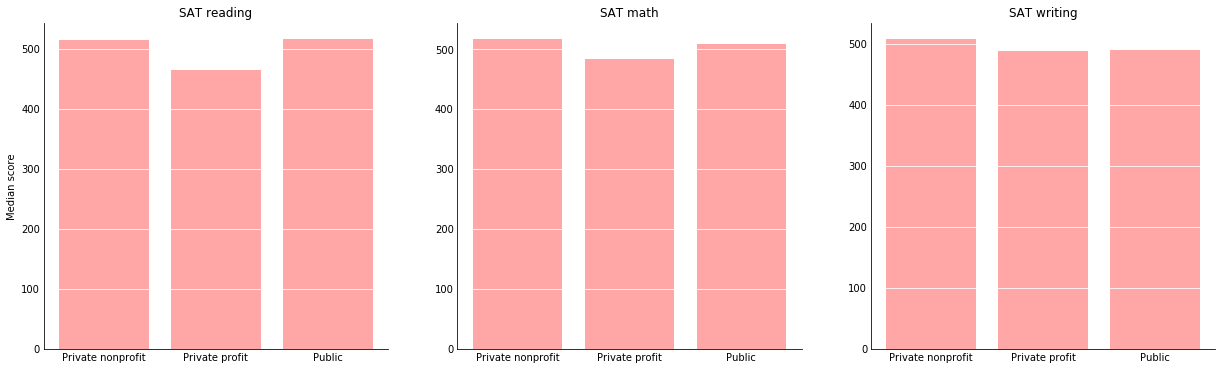

In [330]:
fig, ax = plt.subplots(1, 3, figsize=(21,6))

# Set up the color scheme. This makes it easier to fiddle with.
bar_color = 'red'
bar_alpha = 0.35

# Plot one SAT variable on each axes
ax[0].bar(bach_sat_med.index, bach_sat_med['sat_math_med'], color=bar_color, alpha=bar_alpha)
ax[1].bar(bach_sat_med.index, bach_sat_med['sat_read_med'], color=bar_color, alpha=bar_alpha)
ax[2].bar(bach_sat_med.index, bach_sat_med['sat_write_med'],color=bar_color, alpha=bar_alpha)

# Titles!
ax[0].set_title('SAT reading')
ax[1].set_title('SAT math')
ax[2].set_title('SAT writing')

# I am only setting the ylabel on the left-most. Save some non-data ink.
ax[0].set_ylabel('Median score')

# Set these common parameters by looping over the axes.
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid(axis='y', color='white')                # Still experimenting with this...
    a.xaxis.set_tick_params(length=0)              # Kill the xaxis ticks
    a.yaxis.set_tick_params(length=0)              # Kill the yaxis ticks
    
plt.show()


Interesting. Private for-profit institutions seem to have about the same quality of writing scores, a bit lower math scores and substantially lower reading scores. Once we fire up some stats model packages, we can do formal tests to see if they are significantly different.  

## Practice

1. Create a dataset with only public institutions. Name it `pub`

In [331]:
pub = colscd[colscd['ownership']=='Public']

The `quantile( )` method computes quantiles from the data. (e.g., `quantile(0.5)` computes the median, or the the 50th quantile)

2. Let's look at a measure of the earnings spread for different institution types

    a. Compute the 75th quantile for 'earn_10' for each 'type'.
    
    b. Compute the 50th quantile for 'earn_10' for each 'type'.
    
    c. Compute the 25th quantile for 'earn_10' for each 'type'.

In [248]:
q75 = pub.groupby('type')[['earn_10']].quantile(0.75)
q50 = pub.groupby('type')[['earn_10']].quantile(0.50)
q25 = pub.groupby('type')[['earn_10']].quantile(0.25)

2d. For each type, compute the difference between the 75 percentile and the 25 percentile and divide it by the median.

In [249]:
spread = (q75 - q25)/ q50
spread

0.75,earn_10
type,
asc,0.197
bach,0.264
cert,0.268
grad_only,0.917
na,0.202


Wow, a lot of dispersion in the grad_only group. Let's practice some more. 



3. How do reading and writing scores correlate?

    a. Compute the median SAT reading and writing scores by state.


In [332]:

sat_rw_med = pub.groupby('state')[['sat_read_med', 'sat_write_med']].median()
sat_rw_med.head()

,sat_read_med,sat_write_med
state,,
AK,540.0,510.0
AL,509.0,514.0
AR,476.0,450.0
AS,NaN,NaN
AZ,542.5,NaN


3b. Create a scatter plot with the median reading score on the x axis and writing score on the y axis. 

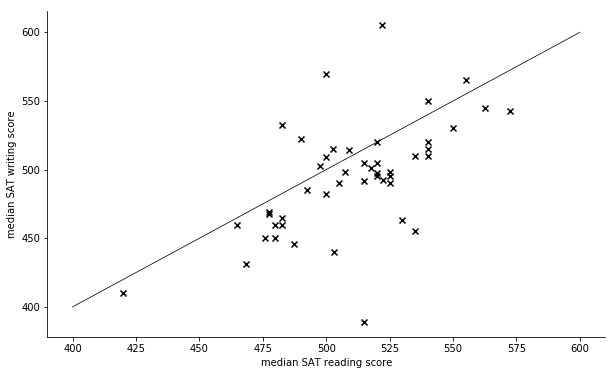

In [333]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(sat_rw_med['sat_read_med'], sat_rw_med['sat_write_med'], color='black', marker='x')
ax.plot([400, 600], [400, 600], color='black', linewidth=0.75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('median SAT reading score')
ax.set_ylabel('median SAT writing score')

plt.show()

### Working with quantiles


In [334]:
bus_quart = pd.cut(colscd['sh_bus'], 3, right=False)
bus_quart[:10]

name
Alabama A & M University               [0.0, 0.333)
University of Alabama at Birmingham    [0.0, 0.333)
Amridge University                     [0.0, 0.333)
University of Alabama in Huntsville    [0.0, 0.333)
Alabama State University               [0.0, 0.333)
The University of Alabama              [0.0, 0.333)
Central Alabama Community College      [0.0, 0.333)
Athens State University                [0.0, 0.333)
Auburn University at Montgomery        [0.0, 0.333)
Auburn University                      [0.0, 0.333)
Name: sh_bus, dtype: category
Categories (3, interval[float64]): [[0.0, 0.333) < [0.333, 0.667) < [0.667, 1.001)]

Remember, cut returns a Categorical object. We can use this object as our key variable in a groupby.

In [335]:
earn_bus = colscd.groupby(bus_quart)['earn_10']

Notice that we have used a key variable that was not a column of the DataFrame 'colscd'. The key variable can be very general. McKinney covers some other kinds of key variables. 

We now have a DatFrameGroupedBy object. What is the distribution of institutions?

In [336]:
earn_bus.count()

sh_bus
[0.0, 0.333)      3513
[0.333, 0.667)     675
[0.667, 1.001)     792
Name: earn_10, dtype: int64

### Several statistics at once
Once we have grouped our data, we have been hitting it with methods to compute statistics: mean(), count(),...

We now introduced the `agg( )` method, which lets us compute several moments at once --- you can even pass it a user defined function. 

In [338]:
# This is the same as earn_bus.count()
earn_bus.agg('count')

sh_bus
[0.0, 0.333)      3513
[0.333, 0.667)     675
[0.667, 1.001)     792
Name: earn_10, dtype: int64

In [340]:
# But agg() lets us compute many stats at once
earn_bus.agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
sh_bus,,,,
"[0.0, 0.333)",3513,35156.732,34200.0,12982.761
"[0.333, 0.667)",675,30551.852,29000.0,8503.932
"[0.667, 1.001)",792,33015.152,27600.0,15809.740


Schools that focus on business outcomes don't seem to offer greater earnings opportunities. 

## Practice
1. Write a function that returns the average of the 5 largest elements of a Series (a column of a DataFrame). Name the function 'avg5'.

In [343]:
def avg5(x):
    top5 = x.sort_values()[-5:]   # sort x, then grab the five largest. sort defaults to descending
    return top5.mean()            # return the mean 

2. Test your function on column 'a' of the DataFrame defined below. The answer should be 8.

In [344]:
test = pd.DataFrame({'a':[1, 4, 6, 9, 10, 3, 7, 8], 'b':[2, 3, 4, 5, 6, 7, 8, 10] })

In [345]:
avg5(test['a'])

8.0

3. Drop any observation that has 'debt_at_grad' == NaN
4. Compute the mean, median, and avg5  'debt_at_grad' by 'ownership'. Compute them all at once using `agg()`.

In [346]:
colscd.dropna(subset=['debt_at_grad'] , inplace=True)   # Drop the missing values

colscd.groupby('ownership')['debt_at_grad'].agg(['mean', 'median', avg5]) # Compute the summary stats

,mean,median,avg5
ownership,,,
Private nonprofit,22392.133,24781.5,43574.2
Private profit,14317.832,10572.0,47185.7
Public,14210.938,12000.0,34669.2
